In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader as dr
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from itertools import cycle
from matplotlib import style
import seaborn as sns

#Import Model Packages 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

import yfinance as yf

In [44]:
import warnings
warnings.filterwarnings("ignore")

style.use("seaborn-white")
sns.set_style("white")
plt.rcParams["figure.figsize"] = (10,6)

# Weekly Tasks

<b> Clustering Algorithm - Portfolio Pairs Trading Strategy </b>

- Download the Python code for implementing a Clustering Algorithm for Pairs Trading (O'reily Chapter 8)
- Use the implementation and necessary historical data to build a pairs trading strategy for your portfolio
- Post your results here.
- Upload your code to the GitHub Classroom
- Summarize your result in a discussion board thread.

<br>
<b> Pairs Trading- finding pairs based on Clustering </b>

For this assignment I will use the investment portfolio defined in week 3 to identify pairs trading strategies. The analysis will use several agorithms to identify clusters of assets that can be used for pairs trading. 

# 0. Setup

## 0.1 Variables

In [3]:
start_date = '2023-01-01'
split_date = '2023-09-11'
end_date = '2023-11-10'
lookback_window = 20
zscore_threshold = 1.0

## 0.2 Functions

In [4]:
# Function to fetch stock data
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data['Adj Close']

# Function to perform pairs trading analysis
def pairs_trading_analysis(stock1, stock2, data, start_date, end_date, lookback_window, zscore_threshold):
    
    # filter data
    data = data[[stock1,stock2]].copy()
    data = data[(data.index >= split_date) & (data.index <= end_date)]

    # Calculate spread and z-score
    data['Spread'] = data[stock1] - data[stock2]
    data['Zscore'] = (data['Spread'] - data['Spread'].rolling(window=lookback_window).mean()) / data['Spread'].rolling(window=lookback_window).std()

    # Initialize positions and P&L
    data['PositionStock1'] = 0
    data['PositionStock2'] = 0
    data['ProfitLoss'] = 0

    # Simulate trades
    for i in range(1, len(data)):
        if data['Zscore'].iloc[i] > zscore_threshold:
            # Sell stock1 and buy stock2
            data['PositionStock1'].iloc[i] = -1
            data['PositionStock2'].iloc[i] = 1
        elif data['Zscore'].iloc[i] < -zscore_threshold:
            # Buy stock1 and sell stock2
            data['PositionStock1'].iloc[i] = 1
            data['PositionStock2'].iloc[i] = -1

        # Calculate daily P&L
        data['ProfitLoss'].iloc[i] = (
            data['PositionStock1'].iloc[i-1] * (data[stock1].iloc[i] - data[stock1].iloc[i-1]) +
            data['PositionStock2'].iloc[i-1] * (data[stock2].iloc[i] - data[stock2].iloc[i-1])
        )

    # Calculate cumulative P&L
    data['CumulativeProfitLoss'] = data['ProfitLoss'].cumsum()

    # Print the last few rows of the data
    #print(data.tail())
    return data

    
def plot_results(data):
    # Plot results
    data[['Spread', 'Zscore']].plot(subplots=True, figsize=(12, 8))
    plt.title('Pairs Trading Spread and Z-Score')
    plt.show()
    

    
def plot_trading_profit(s1_name, s2_name, data):

    fig, ax1 = plt.subplots(figsize=(16,8))

    sns.lineplot(data = data, x='Date', y='CumulativeProfitLoss', alpha=0.60, color='darkgreen',  ax=ax1)
    ax2 = ax1.twinx()
    sns.lineplot(color='red' , linestyle="dashed" ,sort=False, data = data, x='Date',y ='PositionStock1',dashes=True, ax=ax2)
    sns.lineplot(color='darkblue' , marker='o' ,sort=False, data = data, x='Date', y='PositionStock2',ax=ax2)


    ymin = min(data['CumulativeProfitLoss']) - 1
    ymax = max(data['CumulativeProfitLoss']) + 1
    ax1.set_ylim(ymin, ymax)
    ax2.set_ylim(-2, 20)

    ax1.tick_params(axis='x', labelrotation=90) 
    xticks = xticks = data.index.tolist()

    plt.axhline(y=0, linestyle="dashed", color='lightgray')

    # annotations
    ax2.set_title(f'Backtest Senario ({s1_name} - {s2_name})');
    ax2.set(xlabel='month', ylabel='Position')
    ax1.set(ylabel='Cummulative Returns')

    plt.show()

# 2. Portfolio Data

## 2.1. Loading the Data

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w11/data/DATA618_Portfolio_Rebalance_v2.csv')
df = df[df['Shares'] > 0]
df['Value'].fillna(0, inplace=True)
df['Class'].fillna('Other', inplace=True)
print('df', df.shape)

ticker_lst = list(df['Ticker'])
ticker_lst.remove('C_A_S_H')

dataset = yf.download(ticker_lst, start=start_date, end=end_date)['Adj Close']
print('dataset', dataset.shape)

df (40, 10)
[*********************100%%**********************]  39 of 39 completed
dataset (216, 39)


## 2.2. Descriptive Statistics

In [6]:
dataset.describe()

,ALTVX,ARKK,BLUEX,BPLSX,DFAR,EXAS,FREL,FSMD,GARIX,GCHDX,...,TWLO,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
count,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,...,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000
mean,9.484056,40.082369,34.053148,14.572130,20.870911,74.203889,24.274823,32.416890,18.703750,10.492593,...,60.158148,160.826651,9.890071,18.411642,21.083220,73.040884,80.768907,211.359014,65.632339,49.068445
std,0.181272,3.762344,0.930048,0.351347,0.983342,12.228001,1.175009,1.080995,0.775991,0.287564,...,5.810662,6.979280,0.217115,0.270603,0.436291,1.953959,3.902074,7.539194,5.234405,0.711884
min,9.010000,30.208069,31.350000,13.780000,18.450001,47.189999,21.370001,30.350000,17.379999,9.670000,...,45.830002,148.591858,9.410000,17.650000,19.930000,68.396423,71.050003,195.660004,53.716915,47.242149
25%,9.420000,37.870417,33.377501,14.320000,20.350444,65.162498,23.651393,31.491701,18.000000,10.310000,...,56.285001,154.849449,9.720000,18.264974,20.853515,71.737177,78.712971,205.449142,60.982077,48.784579
50%,9.550000,39.345989,34.155001,14.615000,20.930933,67.820000,24.283053,32.386906,18.755000,10.560000,...,60.809999,160.911873,9.920000,18.464750,21.182944,73.254772,80.803192,210.765251,67.299999,49.301825
75%,9.609101,42.579890,34.662501,14.872500,21.458979,83.625000,25.003506,33.149512,19.469999,10.710000,...,64.119999,166.499325,10.070343,18.610836,21.400000,74.617802,83.142132,216.659458,70.283876,49.588557
max,9.720000,50.231083,35.840000,15.160000,23.451689,99.040001,27.310402,34.570412,19.790001,10.960000,...,75.449997,174.735031,10.270000,18.910521,21.782394,76.622124,90.850349,227.400925,73.265915,50.211536


## 2.3. Data Cleaning

First step is to check for the NAs in the rows, either drop them or fill them with the mean of the column.

In [7]:
print('Null Values =',dataset.isnull().values.any())

Null Values = False


## 2.4. Data Transformation

The annual returns and variance for the assets in the portfolio will be used for the cluster analysis. The portfolio dataframe is extended to include a column for returns data and column for asset volitiltity. The variables will be scaled prior to clustering to ensure that features with large values do not dominate the results. The StandardScaler in sklearn is used to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1). The X dataset is in the format for clustering with the parameters as indices and clustering variables as the columns.

In [8]:
#Calculate average annual percentage return and volatilities over a theoretical one year period
returns = dataset.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = dataset.pct_change().std() * np.sqrt(252)
data=returns


# StandardScaler
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)


# summarize transformed data
X=rescaledDataset
X.head()


,Returns,Volatility
ALTVX,-0.217798,-0.702625
ARKK,1.465858,1.253520
BLUEX,0.256034,-0.361866
BPLSX,0.193995,-0.377071
DFAR,-0.361217,0.137960


# 3. Evaluate Algorithms and Models

We will look at the following models to develop clusters of stocks that can be used for pairs trading:

1. KMeans
2. Hierarchical Clustering (Agglomerative Clustering)
3. Affinity Propagation 

## 3.1. K-Means Clustering

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. 

- Inertia can be recognized as a measure of how internally coherent clusters are

### Finding optimal number of clusters

In this step we look at the following metrices:

1. Sum of square errors (SSE) within clusters
2. Silhouette score.

Inspecting the sum of squared errors chart, it appears the elbow “kink” occurs 3 or 4
clusters for this data. Certainly, we can see that as the number of clusters increase pass
4, the sum of square of errors within clusters plateaus off.

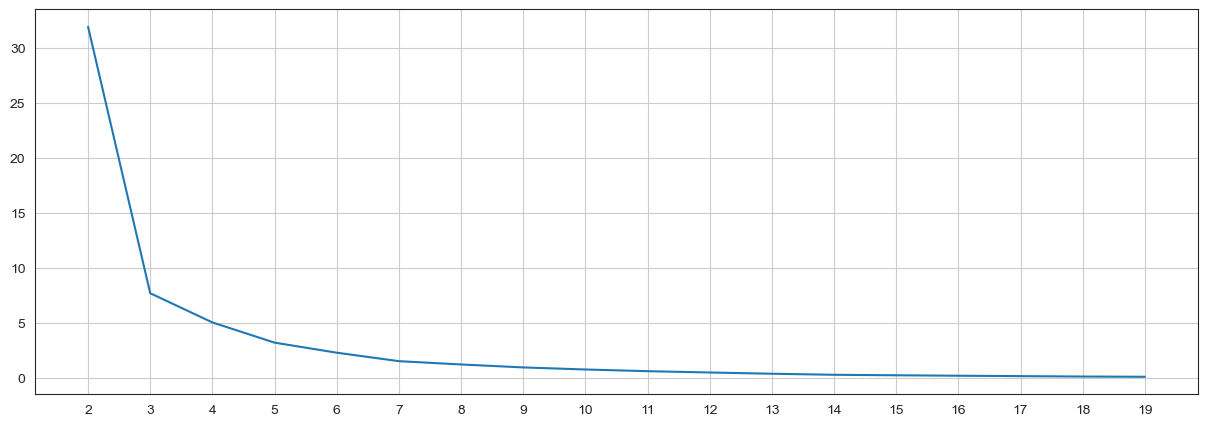

In [43]:
distorsions = []
max_loop=20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)
    
    
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=0)
plt.grid(True)

#### Silhouette score

From the silhouette score chart, we can see that there are various parts of the graph
where a kink can be seen. Since there is not much a difference in SSE after 4 clusters,
we would prefer 4 clusters in the K-means model.

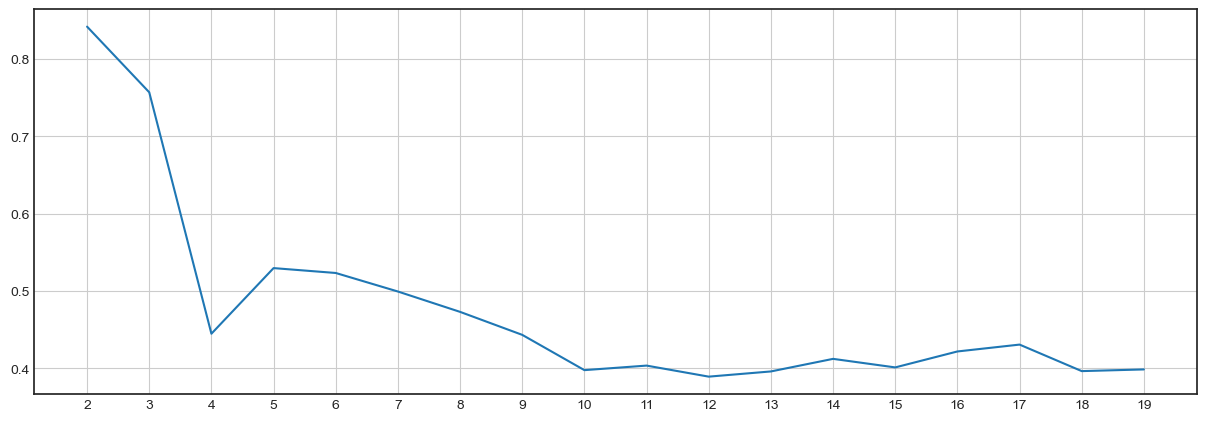

In [71]:
from sklearn import metrics

silhouette_score = []
for k in range(2, max_loop):
        #kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10, n_jobs=-1)
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X)        
        silhouette_score.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=0)
plt.grid(True)

<a id='5.1.2'></a>
### 5.1.2.  Clustering and Visualisation

Let us build the k-means model with four clusters and visualize the results.

In [50]:
# number of clusters
nclust=4

#Fit with k-means
k_means = cluster.KMeans(n_clusters=nclust)
k_means.fit(X)

#Extracting labels 
target_labels = k_means.predict(X)

Visualizing how your clusters are formed is no easy task when the number of variables/dimensions in your dataset is very large. One of the methods of visualising a cluster in two-dimensional space.

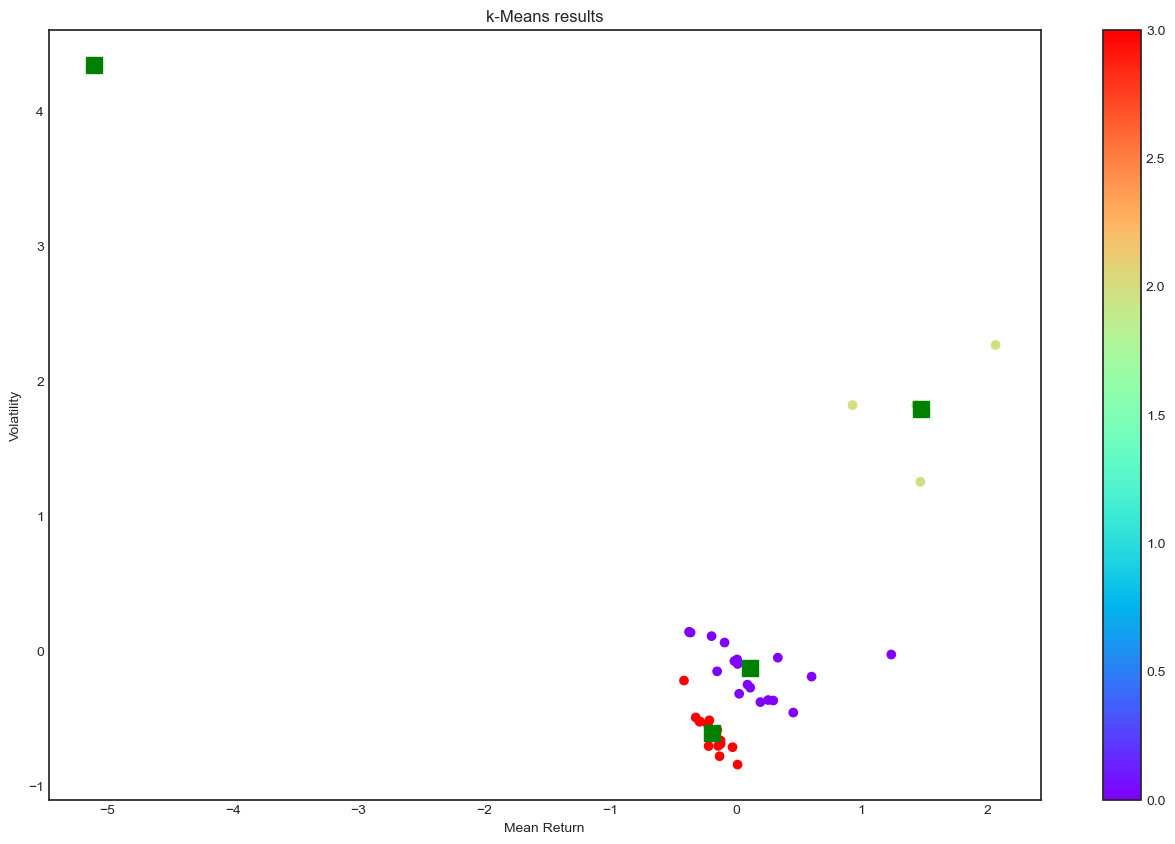

In [51]:
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
ax.set_title('k-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

_ = plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

Let us check the elements of the clusters. The number of stocks in a cluster range from around 1 to 20. Although, the distribution is not equal, we have significant number of stocks in each cluster (with the exception of 1).

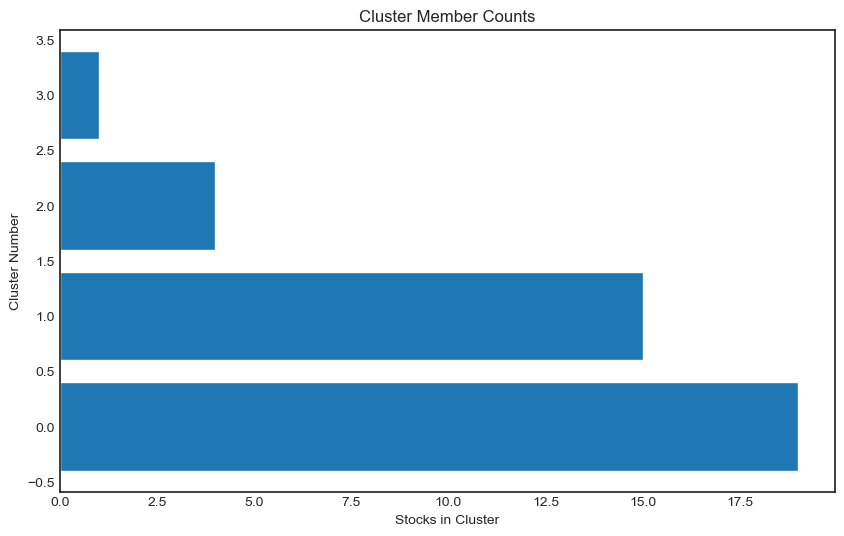

In [76]:
# show number of stocks in each cluster
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]

plt.figure(figsize=(10,6))
plt.barh(
    range(len(clustered_series.value_counts())), # cluster labels, y axis
    clustered_series.value_counts()
)
plt.tick_params(axis='both', which='minor', length=1)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

<br><br>

## 3.2. Hierarchical Clustering (Agglomerative Clustering)

The basic idea is to use a dendrogram to visualize the hierarchical relationships between stocks based on their historical price movements. Stocks that are close to each other in the dendrogram may exhibit similar price behaviors and can be considered for pairs trading. 

In the first step we look at the hierarchy graph and check for the number of clusters


### Building Hierarchy Graph/ Dendogram

The hierarchy class has a dendrogram method which takes the value returned by the linkage method of the same class. The linkage method takes the dataset and the method to minimize distances as parameters. We use 'ward' as the method since it minimizes then variants of distances between the clusters.

The best way to visualize an agglomerate clustering algorithm is through a dendogram, which displays a cluster tree, the leaves being the individual stocks and the root being the final single cluster. The "distance" between each cluster is shown on the y-axis, and thus the longer the branches are, the less correlated two clusters are.

Once one big cluster is formed, the longest vertical distance without any horizontal line passing through it is selected and a horizontal line is drawn through it. The number of vertical lines this newly created horizontal line passes is equal to number of clusters.
Then we select the distance threshold to cut the dendrogram to obtain the selected clustering level. The output is the cluster labelled for each row of data. As expected from the dendrogram, a cut at 2 gives us four clusters.

linkage Z [6.0000000e+00 3.5000000e+01 3.8940231e-03 2.0000000e+00]


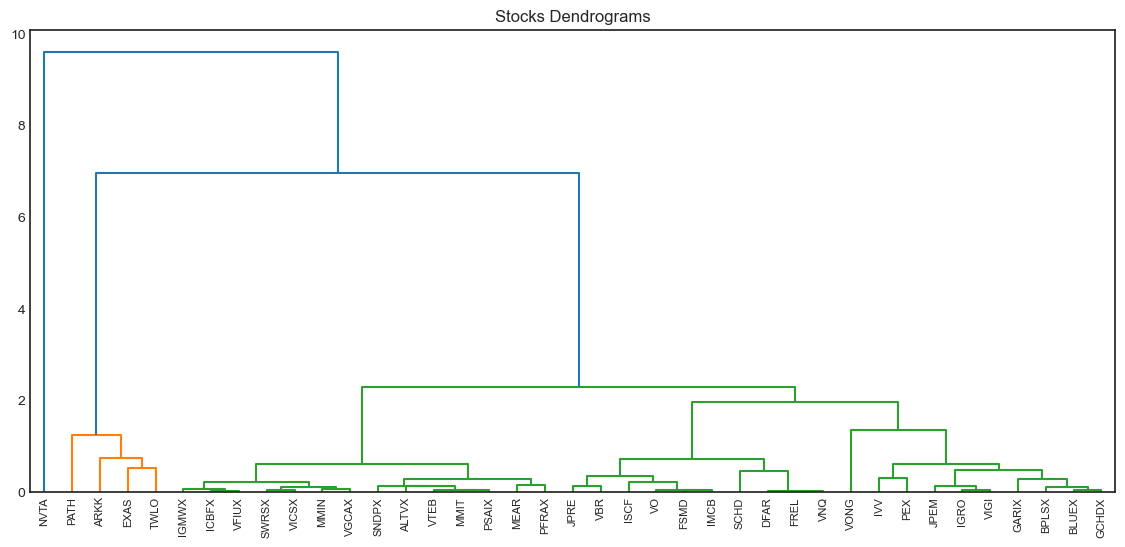

In [74]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

#Calulate linkage
Z= linkage(X, method='ward')
print('linkage Z', Z[0])

#Plot Dendogram
plt.figure(figsize=(14, 6))
plt.title("Stocks Dendrograms")
dendrogram(Z,labels = X.index)
plt.xticks(rotation=90)
plt.show()

In [66]:
distance_threshold = 2
clusters = fcluster(Z, distance_threshold, criterion='distance')
chosen_clusters = pd.DataFrame(data=clusters, columns=['cluster'])
chosen_clusters['cluster'].unique()

array([2, 1, 3, 4], dtype=int32)

### Clustering and Visualisation

Similar to the plot of k-means clustering, we see that there are some distinct clusters
separated by different colors. 

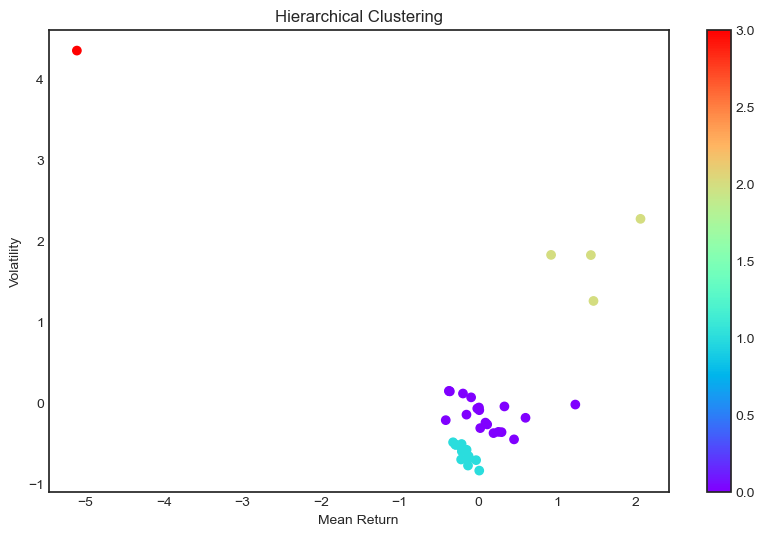

In [75]:
nclust = 4
hc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')
clust_labels1 = hc.fit_predict(X)


fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels1, cmap ="rainbow")
ax.set_title('Hierarchical Clustering')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
_ = plt.colorbar(scatter)

<br>

## 3.3. Affinity Propagation

Affinity Propagation is a clustering algorithm that identifies exemplars in a dataset and forms clusters based on similarity measures. While it's not a traditional hierarchical clustering algorithm, it doesn't require specifying the number of clusters in advance. Instead, it determines the number of clusters based on the data.

Similar to the plot of k-means clustering, we see that there are some distinct clusters separated by different colors. 

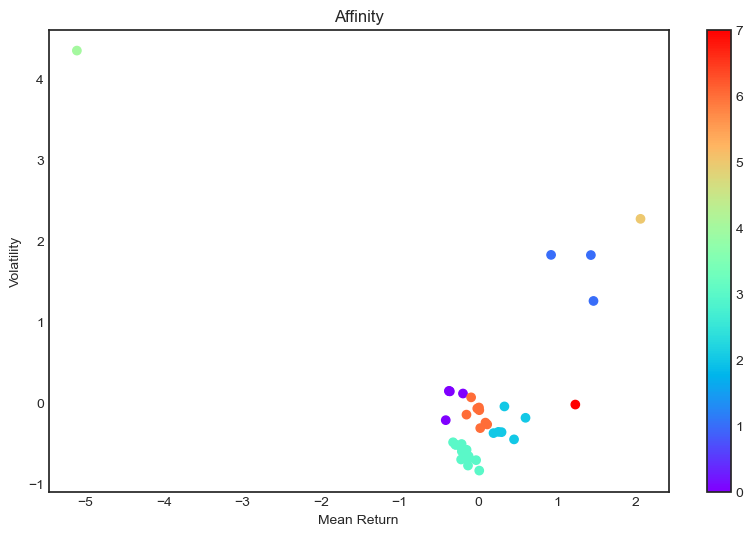

In [79]:
ap = AffinityPropagation()
ap.fit(X)
clust_labels2 = ap.predict(X)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels2, cmap ="rainbow")
ax.set_title('Affinity')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
_ = plt.colorbar(scatter)

### Cluster Visualisation

Estimated number of clusters: 8


<Figure size 1000x600 with 0 Axes>

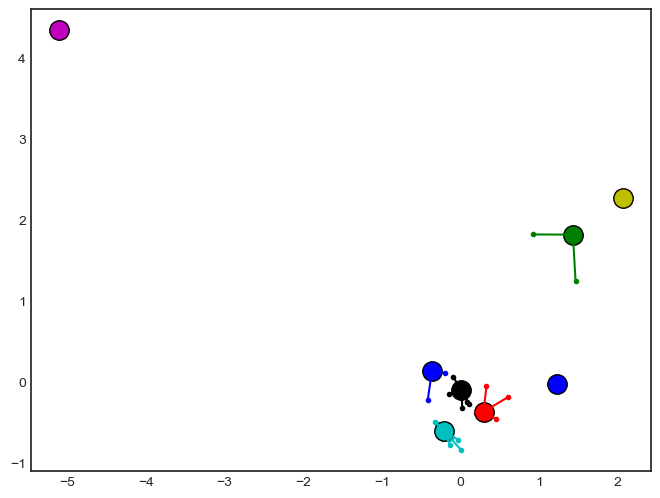

In [80]:
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_

no_clusters = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % no_clusters)
# Plot exemplars

X_temp=np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf()

fig = plt.figure(figsize=(8,6))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(no_clusters), colors):
    class_members = labels == k
    cluster_center = X_temp[cluster_centers_indices[k]]
    plt.plot(X_temp[class_members, 0], X_temp[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in X_temp[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

_ = plt.show()

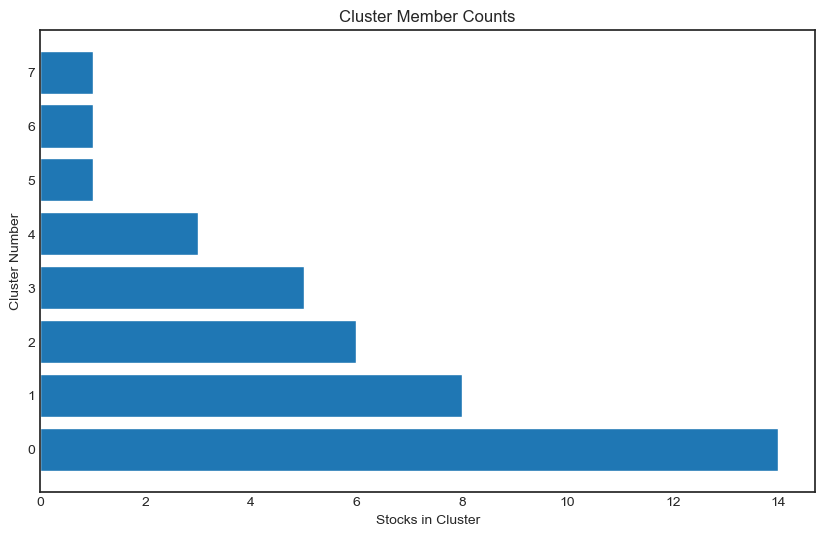

In [81]:
# show number of stocks in each cluster
clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
# clustered stock with its cluster label
clustered_series_all_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series_ap = clustered_series_ap[clustered_series != -1]

plt.figure(figsize=(10,6))
plt.barh(
    range(len(clustered_series_ap.value_counts())), # cluster labels, y axis
    clustered_series_ap.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

<br>

## 3.4. Cluster Evaluation

If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores.

Given the affinity propagation performs the best, we go ahead with the affinity propagation and use 8 clusters as specified by this clustering method

In [85]:
from sklearn import metrics
print("km", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("hc", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("ap", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

km 0.4448231492926325
hc 0.4432770663229591
ap 0.4730695704824963


### Visualising the return within a cluster

The understand the intuition behind clustering, let us visualize the results of the clusters.

In [104]:
# all stock with its cluster label (including -1)
clustered_series = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())
# clustered stock with its cluster label
clustered_series_all = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())
clustered_series = clustered_series[clustered_series != -1]

# get the number of stocks in each cluster
counts = clustered_series_ap.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<25) & (counts>1)].index)[::-1]
#cluster_vis_list = list(counts[(counts<25)].index)[::-1]
print('cluster_vis_list: ', cluster_vis_list)

CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Clusters formed: %d" % len(ticker_count_reduced))
print ("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

cluster_vis_list:  [1, 0, 2, 6, 3]
Clusters formed: 5
Pairs to evaluate: 294


<Figure size 1000x600 with 0 Axes>

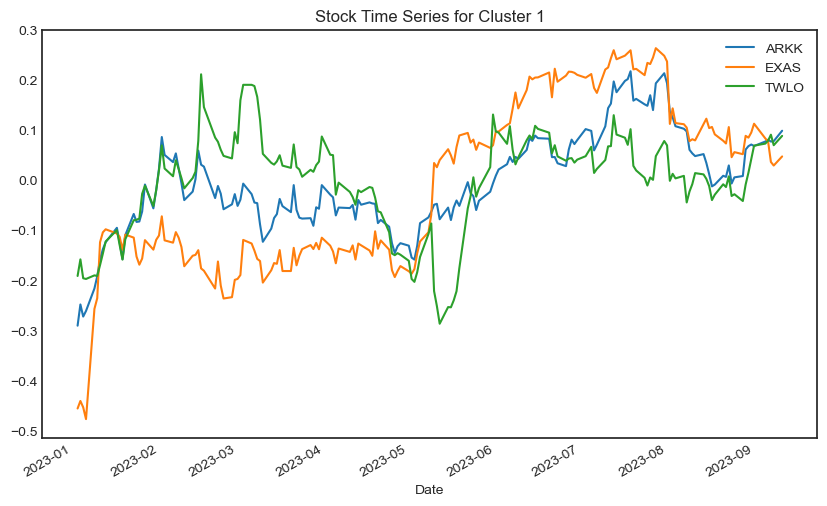

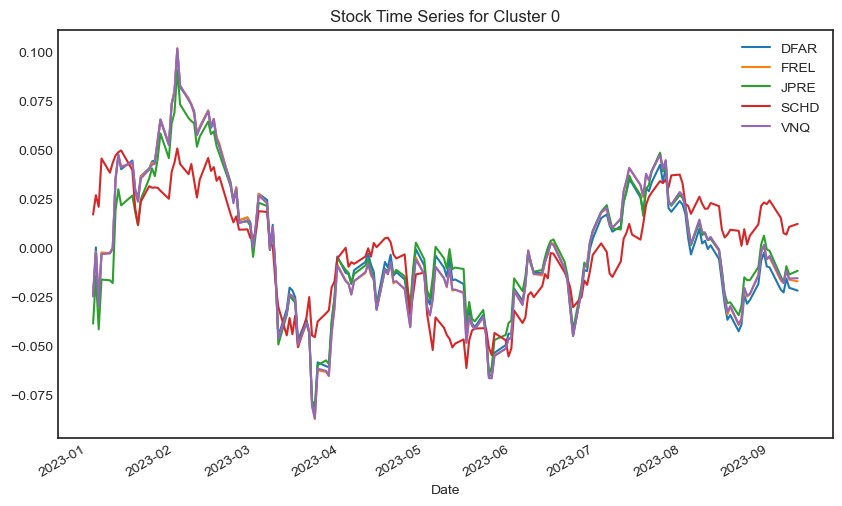

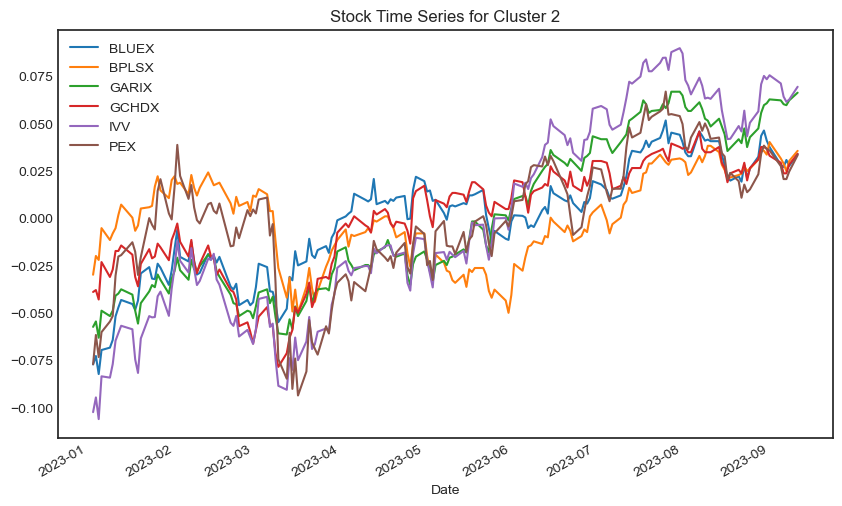

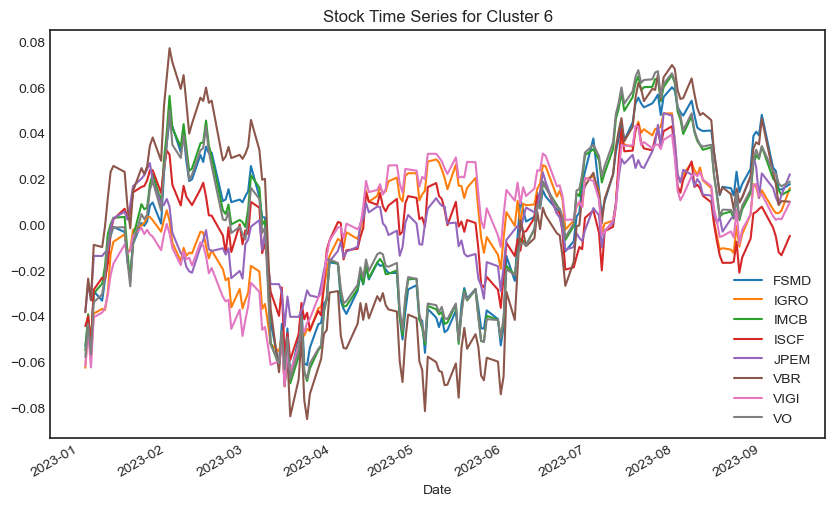

In [105]:
# plot a handful of the smallest clusters
plt.figure(figsize=(10,6))
cluster_vis_list[0:min(len(cluster_vis_list), 4)]

for clust in cluster_vis_list[0:min(len(cluster_vis_list), 4)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(dataset.loc[:split_date, tickers].mean())
    data = np.log(dataset.loc[:split_date, tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)
    
plt.show()

Looking at the charts above, across all the clusters with small number of stocks, we
see similar movement of the stocks under different clusters, which corroborates the
effectiveness of the clustering technique.

# 4. Pairs Selection

## 4.1. Cointegration and Pair Selection Function

In [30]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [31]:
from statsmodels.tsa.stattools import coint
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index   
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        dataset[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [32]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [33]:
print ("Number of pairs found : %d" % len(pairs))
print ("In those pairs, there are %d unique tickers." % len(np.unique(pairs)))

Number of pairs found : 7
In those pairs, there are 10 unique tickers.


In [34]:
pairs

[('ALTVX', 'ICBFX'),
 ('ALTVX', 'IGMWX'),
 ('ALTVX', 'SWRSX'),
 ('ALTVX', 'VGCAX'),
 ('ALTVX', 'VICSX'),
 ('FSMD', 'VO'),
 ('DFAR', 'JPRE')]


## 4.2. Pair Visualization

In [35]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=X.index, data=X).T

In [36]:
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.T.loc[stocks]

In [37]:
X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

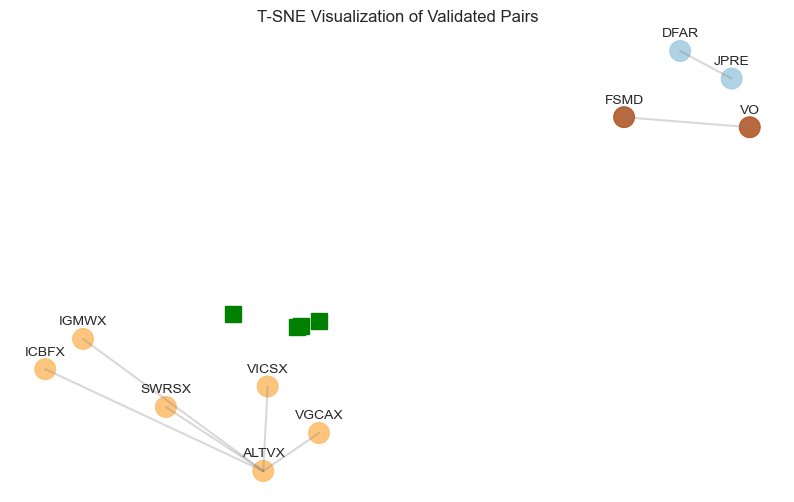

In [106]:
plt.figure(1, facecolor='white',figsize=(10,6))
plt.clf()
plt.axis('off')
for pair in pairs:
    #print(pair[0])
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    #print(ticker1, loc1)

    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs'); 

# zip joins x and y coordinates in pairs
for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):

    label = name

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)


# 5. Clustering Summary

The clustering techniques do not directly help in stock trend prediction. However,
they can be effectively used in portfolio construction for finding the right pairs,
which eventually help in risk mitigation and one can achieve superior risk adjusted
returns.

Clustering can effectively be used for dividing stocks into groups with “similar characteristics” for many other kinds of trading strategies and can help in portfolio construction to ensure we choose a universe of stocks with sufficient diversification
between them.

Finally I will visualize the stock trends of the trading pairs identified by the clustering algorithms. What is clear is that although there is an opportunity to generate returns from pairs trading the cumulative returns over the portfolios history is small. To generate meaningful returns signficant scale is required. 

In [107]:
pairs_df = pd.DataFrame(pairs)
pairs_df.columns = ['Stock1','Stock2']
pairs_df

,Stock1,Stock2
0,ALTVX,ICBFX
1,ALTVX,IGMWX
2,ALTVX,SWRSX
3,ALTVX,VGCAX
4,ALTVX,VICSX
5,FSMD,VO
6,DFAR,JPRE


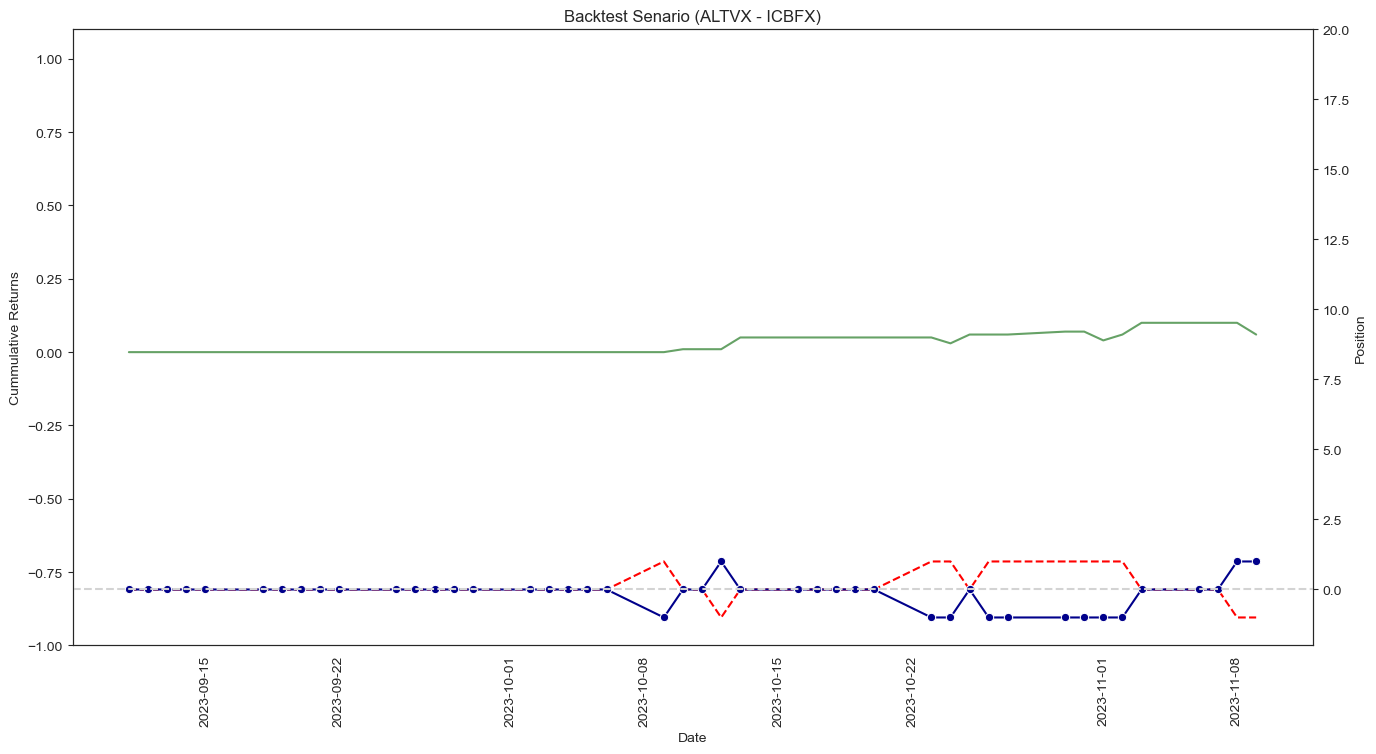

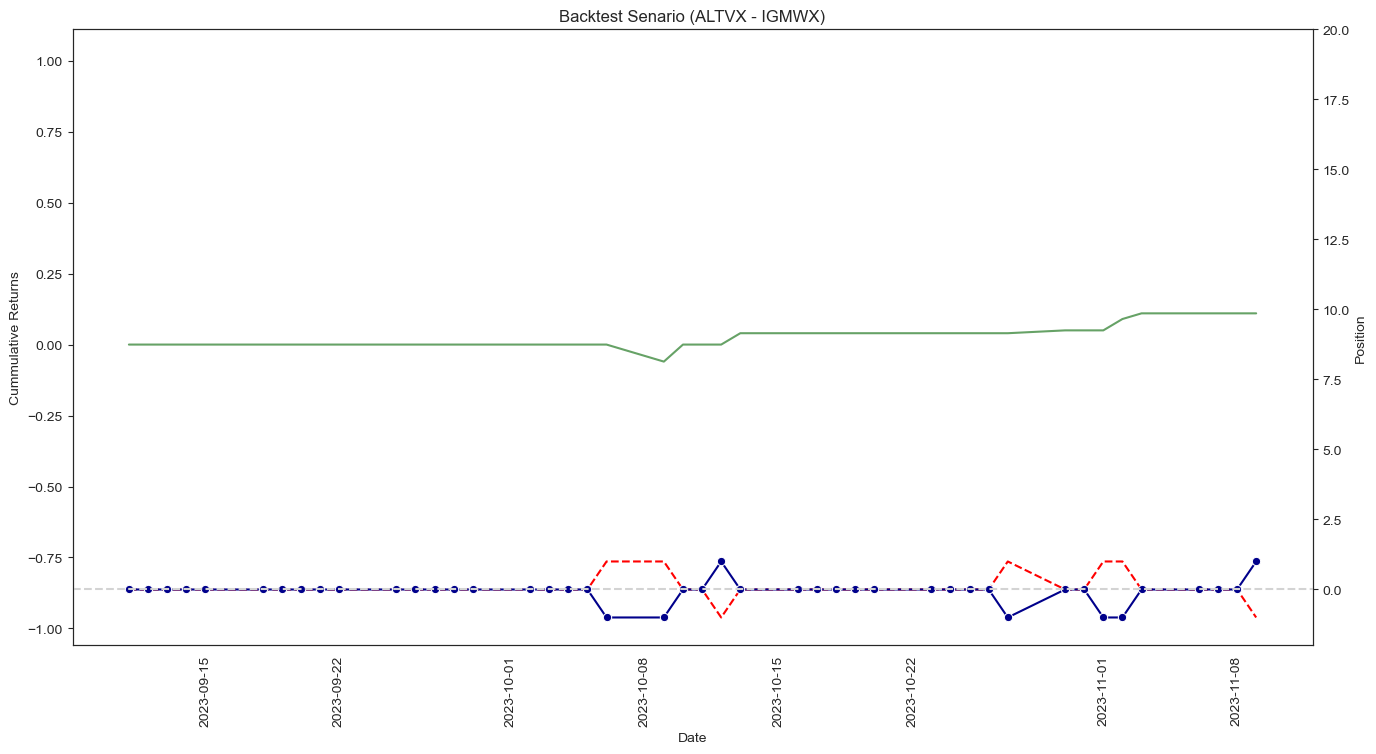

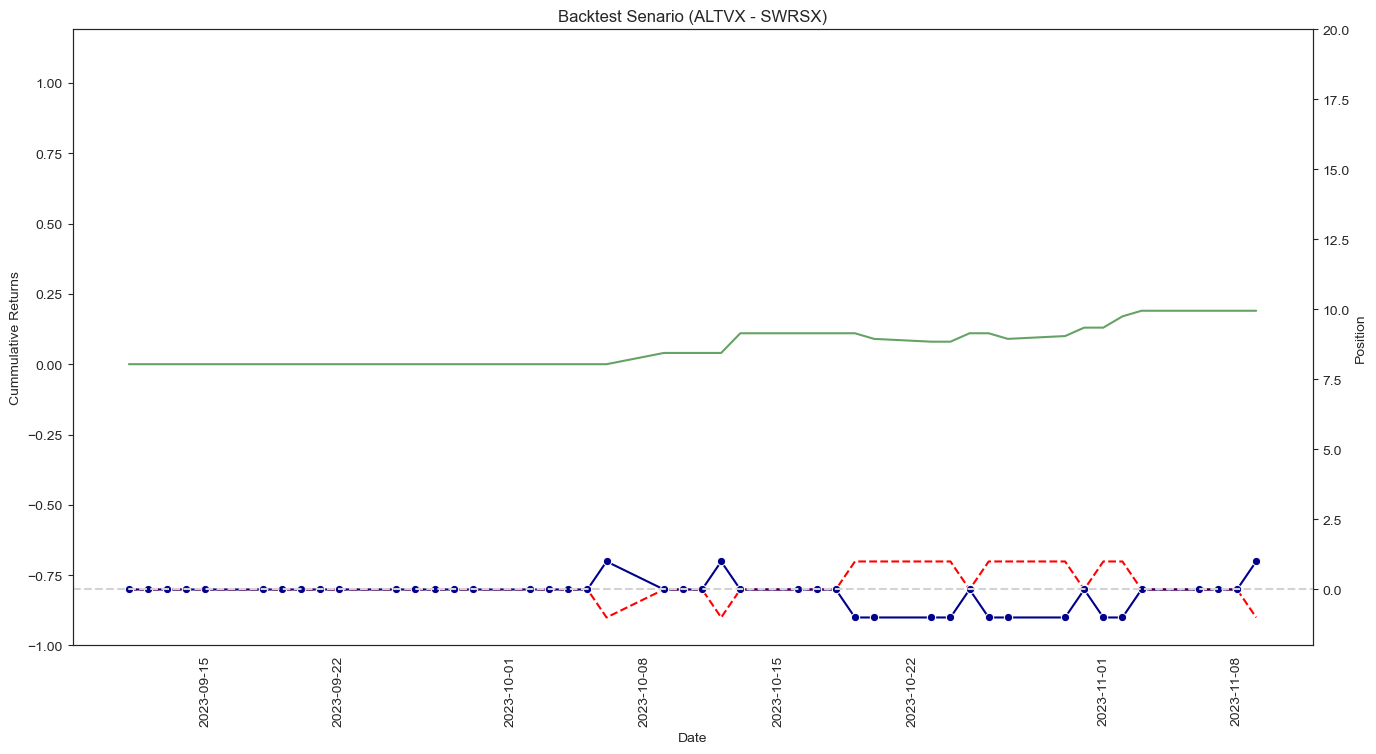

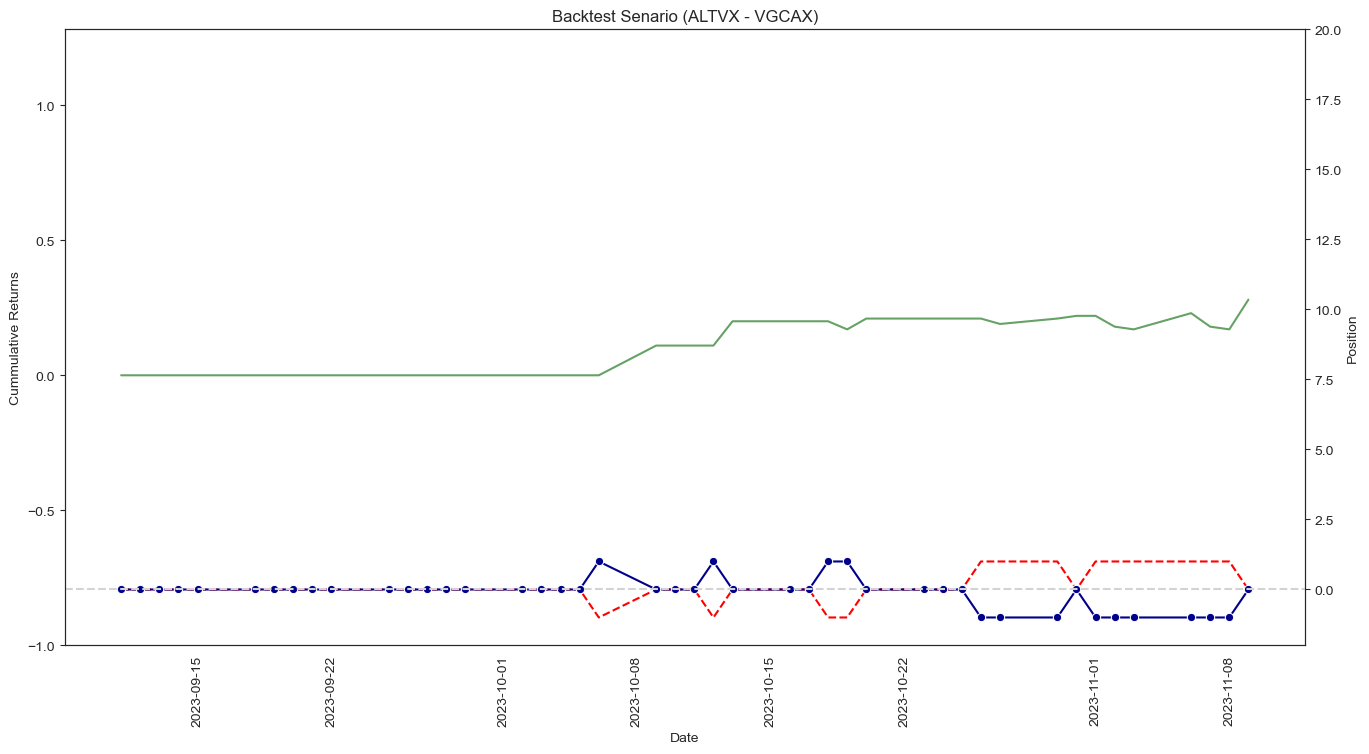

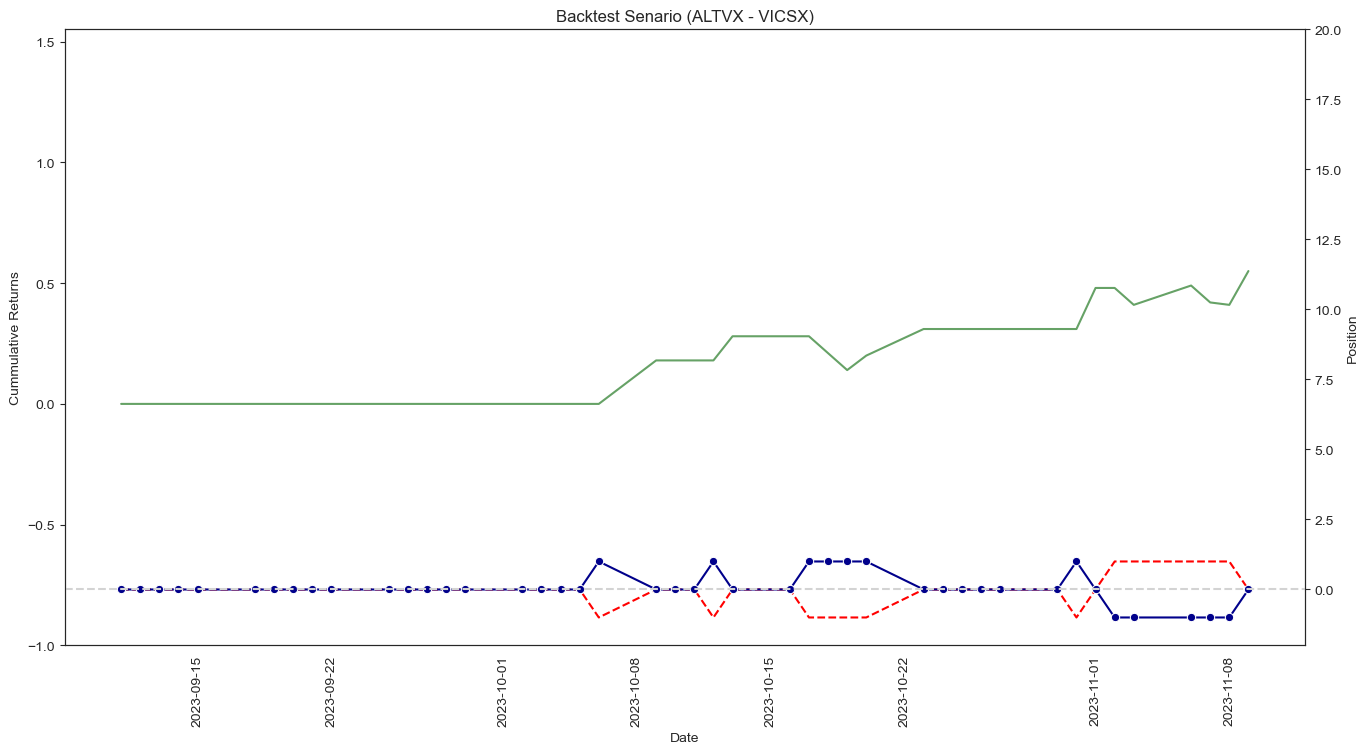

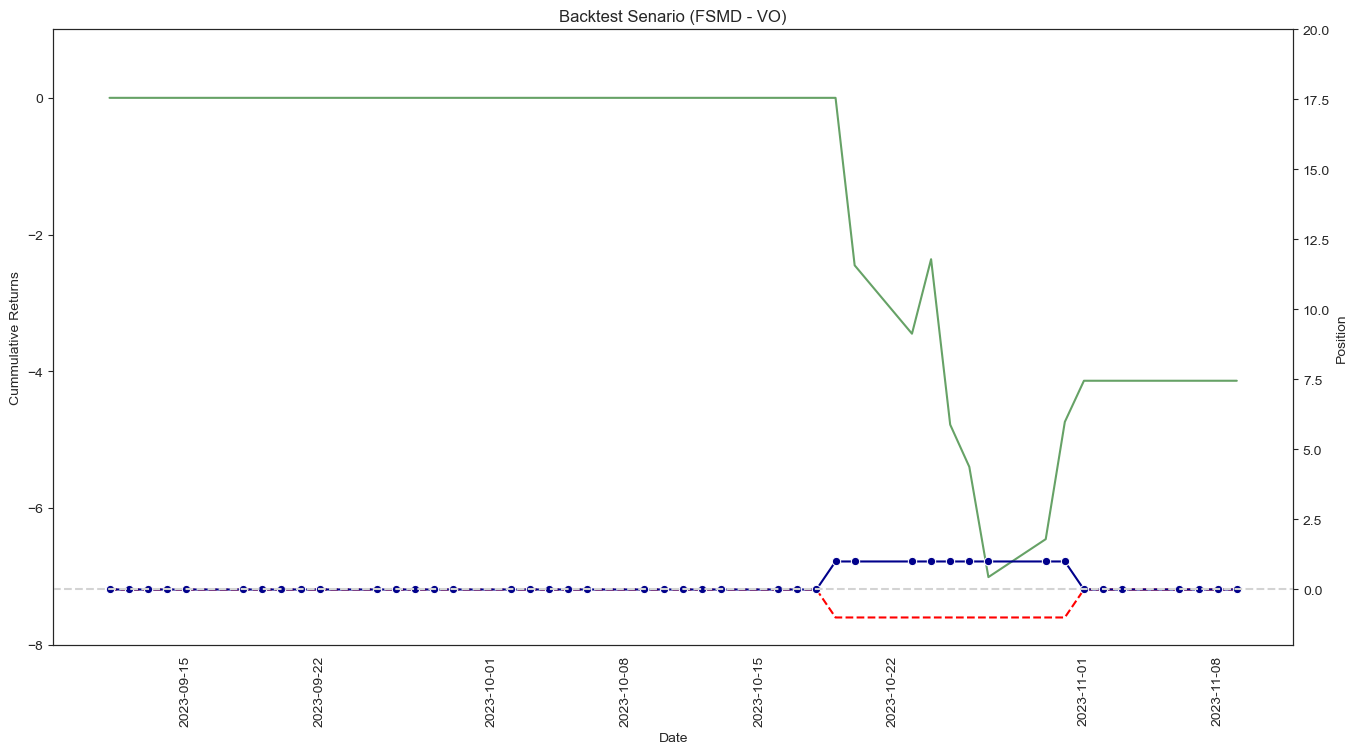

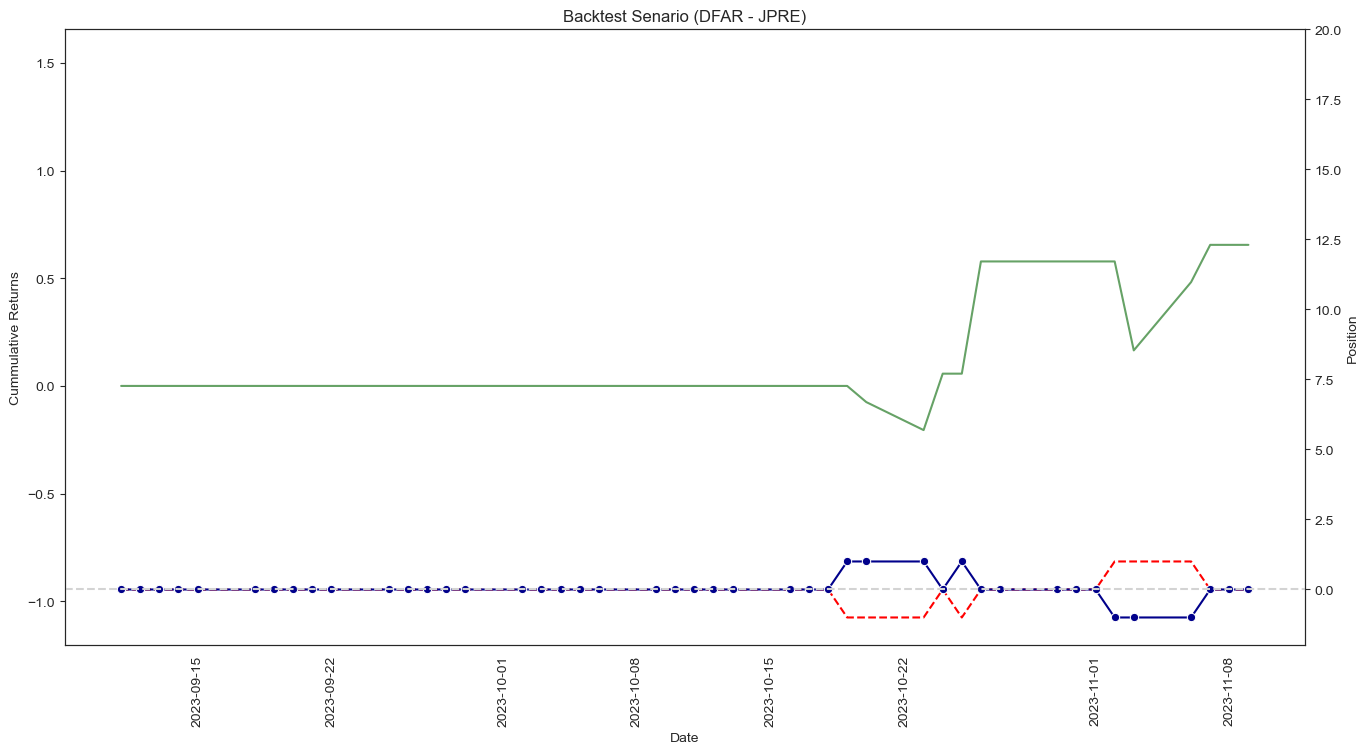

In [40]:
for index, row in pairs_df.iterrows():
    data = pairs_trading_analysis(row['Stock1'], row['Stock2'], dataset, split_date, end_date, lookback_window, zscore_threshold)
    plot_trading_profit(row['Stock1'], row['Stock2'], data)